In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from decimal import Decimal
import sys

In [ ]:
eps = 0.1
n = 25

In [ ]:
def mu1(point, d2):
    return 1 - mu2(point, d2)

def mu2(point, d2, d1=0):
    return 1 / (1 + np.exp(-d2 * (point - d1)))

def func(x, d2):
    return np.array([mu1(x, d2), x * mu1(x, d2), mu2(x, d2), x * mu2(x, d2)])

def make_M(x, p):
    M = np.zeros((len(func(x[0], d2)), len(func(x[0], d2))))
    for i in range(len(x)):
        f = func(x[i], d2)
        M_part = np.zeros((len(f), len(f)))
        for k in range(len(f)):
            for m in range(len(f)):
                M_part[k][m] = f[k] * f[m]
        M += p[i] * M_part
    return M

def add_new_point(x, p, grid, flag, eps):
    M = make_M(x, p)
    D = np.linalg.inv(M)
    D_curr = np.linalg.det(M)
    max, max_point = np.dot(np.dot(func(grid[0], d2), D), func(grid[0], d2).T), grid[0]
    for i in grid:
        f = np.dot(np.dot(func(i, d2), D), func(i, d2).T)
        if f > max: 
            max, max_point = f, i
    if flag:
        x.append(max_point)
        p = calculate_p_new(D_curr, p, x)
    delta = abs(max - np.trace(np.dot(M, D)))
    return delta, max * eps, x, p

def calculate_p_new(D_curr, p, x):
    D_new, k_temp = D_curr - 1, 1
    while D_curr > D_new:
        p_new = p.copy()
        for i in range(len(p_new)):
            p_new[i] = (1.0 - k_temp / len(p_new)) * p_new[i]
        p_new.append(k_temp / len(p_new))
        M_new = make_M(x, p_new)
        D_new = np.linalg.det(M_new)
        k_temp /= 2
    return p_new

def merge_neighboring_points(x, p):
    x_new, p_new = [x[0]], [p[0]]
    for i in range(1, len(x)):
        index = find_close_to_point(x[i], x_new)
        if index == -1:
            x_new.append(x[i]), p_new.append(p[i])
        else:
            p_new[index] += p[i]
    return x_new, p_new

def find_close_to_point(point, X):
    for i in range(len(X)):
        v = np.sqrt((point - X[i]) ** 2)
        if v < 0.03:
            return i
    return -1

def make_plot(x, grid, D, title):
    mu1_list, mu2_list, temp = [], [], list(map(lambda x: np.dot(np.dot(func(x, d2), D), func(x, d2)), grid))
    for i in x:
        mu1_list.append(mu1(i, d2)), mu2_list.append(mu2(i, d2))
        plt.plot([i, i], [0, max(temp)], color='lightgray', alpha=0.7)
        plt.scatter(i, 0, alpha=0.5)
    plt.plot([x[0], x[0]], [0, max(temp)], color='lightgrey')
    plt.plot(grid, temp, 'k')
    plt.plot(x, mu1_list, 'b', label='mu1')
    plt.plot(x, mu2_list, 'b--', label='mu2')
    plt.legend()
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('f(x)')
    plt.show()

def main(eps, n, d2):
    if isinstance(eps, float) == False:
        sys.exit("Error: The precision value must be a float!")
    if isinstance(n, int) == False:
        sys.exit("Error: The number of elements must be an integer!")
    print("d2:", d2, "\nn:", n, "\neps:", eps, "\n")

    x, p = list(np.linspace(-1, 1, n)), [1.0 / n for _ in range(n)]
    M = make_M(x, p)
    D = np.linalg.inv(M)
    grid = np.linspace(-1, 1, 101)
    make_plot(x, grid, D, "Initial plan")
    df_init = pd.DataFrame({'x': x, 'p': p})
    df_init.index += 1
    print(df_init)
    
    delta, iter, iter_sum, k, eps0 = 1, 1, 0, 0, eps
    while abs(delta) > eps:
        m, sum, index = 0, 0, 0
        while delta > eps:
            delta, eps, x, p = add_new_point(x, p, grid, True, eps0)
            m += 1
            if m > 9999:
                break

        x, p = merge_neighboring_points(x, p)

        for i in range(len(p)):
            if p[i] < 0.01:
                sum, index = sum + p[i], index + 1
                p[i], x[i] = 0, 0
        for i in range(index): # removing points with small weights 
            p.remove(0), x.remove(0)
        sum /= len(p)
        for i in range(len(p)):
            p[i] += sum

        k, iter, iter_sum = k + 1, iter + 1, iter_sum + m
        delta, eps, x, p = add_new_point(x, p, grid, False, eps0)

    M = make_M(x, p)
    D = np.linalg.inv(M)
    make_plot(x, grid, D, "Optimal plan")
    df_opt = pd.DataFrame({'x': x, 'p': p})
    df_opt.index += 1
    print(df_opt)
    print("\nOptimal plan built in %s iterations" % iter_sum)

d2: 8 
n: 25 
eps: 0.1 



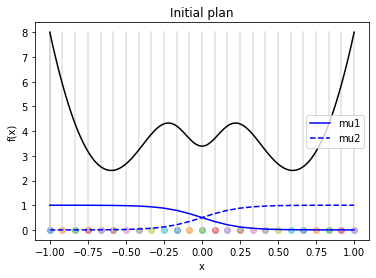

           x     p
1  -1.000000  0.04
2  -0.916667  0.04
3  -0.833333  0.04
4  -0.750000  0.04
5  -0.666667  0.04
6  -0.583333  0.04
7  -0.500000  0.04
8  -0.416667  0.04
9  -0.333333  0.04
10 -0.250000  0.04
11 -0.166667  0.04
12 -0.083333  0.04
13  0.000000  0.04
14  0.083333  0.04
15  0.166667  0.04
16  0.250000  0.04
17  0.333333  0.04
18  0.416667  0.04
19  0.500000  0.04
20  0.583333  0.04
21  0.666667  0.04
22  0.750000  0.04
23  0.833333  0.04
24  0.916667  0.04
25  1.000000  0.04


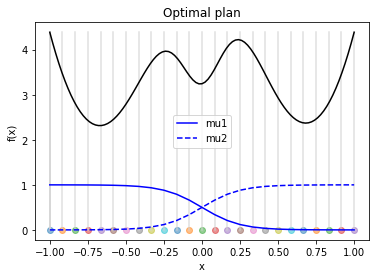

           x         p
1  -1.000000  0.203663
2  -0.916667  0.010099
3  -0.833333  0.010099
4  -0.750000  0.010099
5  -0.666667  0.010099
6  -0.583333  0.010099
7  -0.500000  0.010099
8  -0.416667  0.010099
9  -0.333333  0.010099
10 -0.250000  0.197965
11 -0.166667  0.010099
12 -0.083333  0.010099
13  0.000000  0.010099
14  0.083333  0.010099
15  0.166667  0.010099
16  0.250000  0.182623
17  0.333333  0.010099
18  0.416667  0.010099
19  0.500000  0.010099
20  0.583333  0.010099
21  0.666667  0.010099
22  0.750000  0.010099
23  0.833333  0.010099
24  0.916667  0.010099
25  1.000000  0.203663

Optimal plan built in 48 iterations
CPU times: user 1.75 s, sys: 810 ms, total: 2.56 s
Wall time: 1.75 s


In [ ]:
%%time

d2 = 8

main(eps, n, d2)

d2: 12 
n: 25 
eps: 0.1 



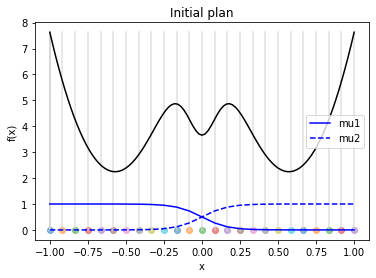

           x     p
1  -1.000000  0.04
2  -0.916667  0.04
3  -0.833333  0.04
4  -0.750000  0.04
5  -0.666667  0.04
6  -0.583333  0.04
7  -0.500000  0.04
8  -0.416667  0.04
9  -0.333333  0.04
10 -0.250000  0.04
11 -0.166667  0.04
12 -0.083333  0.04
13  0.000000  0.04
14  0.083333  0.04
15  0.166667  0.04
16  0.250000  0.04
17  0.333333  0.04
18  0.416667  0.04
19  0.500000  0.04
20  0.583333  0.04
21  0.666667  0.04
22  0.750000  0.04
23  0.833333  0.04
24  0.916667  0.04
25  1.000000  0.04


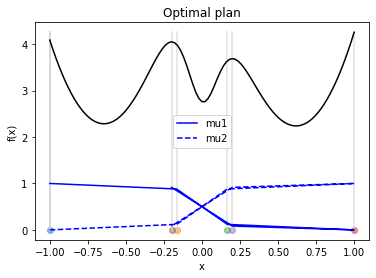

          x         p
1 -1.000000  0.244621
2 -0.166667  0.080635
3  0.166667  0.080635
4  1.000000  0.234929
5  0.200000  0.191704
6 -0.200000  0.167475

Optimal plan built in 54 iterations
CPU times: user 1.58 s, sys: 738 ms, total: 2.32 s
Wall time: 1.53 s


In [ ]:
%%time

d2 = 12

main(eps, n, d2)

d2: 16 
n: 25 
eps: 0.1 



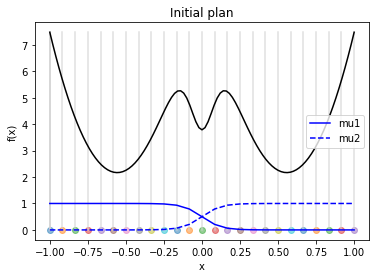

           x     p
1  -1.000000  0.04
2  -0.916667  0.04
3  -0.833333  0.04
4  -0.750000  0.04
5  -0.666667  0.04
6  -0.583333  0.04
7  -0.500000  0.04
8  -0.416667  0.04
9  -0.333333  0.04
10 -0.250000  0.04
11 -0.166667  0.04
12 -0.083333  0.04
13  0.000000  0.04
14  0.083333  0.04
15  0.166667  0.04
16  0.250000  0.04
17  0.333333  0.04
18  0.416667  0.04
19  0.500000  0.04
20  0.583333  0.04
21  0.666667  0.04
22  0.750000  0.04
23  0.833333  0.04
24  0.916667  0.04
25  1.000000  0.04


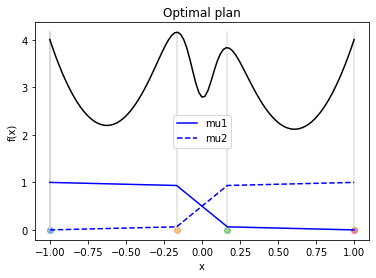

          x         p
1 -1.000000  0.249520
2 -0.166667  0.240308
3  0.166667  0.260652
4  1.000000  0.249520

Optimal plan built in 62 iterations
CPU times: user 1.63 s, sys: 911 ms, total: 2.55 s
Wall time: 1.61 s


In [ ]:
%%time

d2 = 16

main(eps, n, d2)

d2: 20 
n: 25 
eps: 0.1 



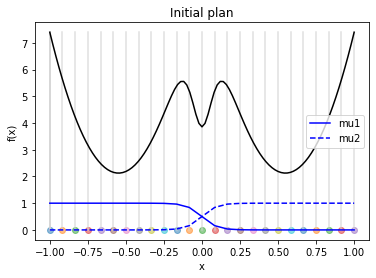

           x     p
1  -1.000000  0.04
2  -0.916667  0.04
3  -0.833333  0.04
4  -0.750000  0.04
5  -0.666667  0.04
6  -0.583333  0.04
7  -0.500000  0.04
8  -0.416667  0.04
9  -0.333333  0.04
10 -0.250000  0.04
11 -0.166667  0.04
12 -0.083333  0.04
13  0.000000  0.04
14  0.083333  0.04
15  0.166667  0.04
16  0.250000  0.04
17  0.333333  0.04
18  0.416667  0.04
19  0.500000  0.04
20  0.583333  0.04
21  0.666667  0.04
22  0.750000  0.04
23  0.833333  0.04
24  0.916667  0.04
25  1.000000  0.04


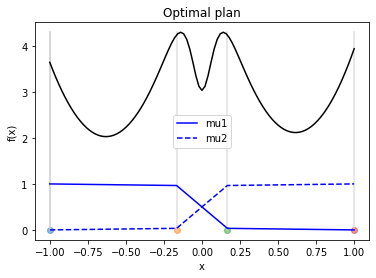

          x         p
1 -1.000000  0.274412
2 -0.166667  0.235876
3  0.166667  0.235876
4  1.000000  0.253835

Optimal plan built in 64 iterations
CPU times: user 1.67 s, sys: 879 ms, total: 2.54 s
Wall time: 1.61 s


In [ ]:
%%time

d2 = 20

main(eps, n, d2)